In [1]:
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install folium


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


2019.01~06 중에 언제 지하철을 가장 많이 이용했을까? (기준: 승하차총승객수)

In [2]:
# 1. 필요한 라이브러리 불러오기

import glob
import math
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium


plt.rcParams['font.family'] ='D2Coding'
plt.rcParams['axes.unicode_minus'] =False

In [3]:
# 2. 현재 사용가능한 데이터 확인

DIRNAME = 'rawfiles'

os.listdir(DIRNAME)

['CARD_SUBWAY_MONTH_201903.csv',
 'CARD_SUBWAY_MONTH_201902.csv',
 'CARD_SUBWAY_MONTH_201901.csv',
 'CARD_SUBWAY_MONTH_201905.csv',
 'CARD_SUBWAY_MONTH_201904.csv',
 'CARD_SUBWAY_MONTH_201906.csv',
 '지하철노선위경도정보2.csv']

In [4]:
# 3. 데이터를 병합하여 하나의 데이터프레임 형성

df_location_raw = pd.read_csv(os.path.join(DIRNAME, '지하철노선위경도정보2.csv'))
df_subway_raw = pd.DataFrame()

for filename in glob.glob(os.path.join(DIRNAME, 'CARD_SUBWAY_MONTH_*.csv')):
    tmp = pd.read_csv(filename)
    df_subway_raw = pd.concat([df_subway_raw, tmp])

In [5]:
df_subway_raw.tail()

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
17719,20190630,7호선,마들,6622.0,6116.0,20190703
17720,20190630,4호선,노원,14071.0,14702.0,20190703
17721,20190630,7호선,중계,9516.0,8981.0,20190703
17722,20190630,7호선,하계,11645.0,11121.0,20190703
17723,20190630,6호선,태릉입구,5730.0,5214.0,20190703


In [6]:
df_subway_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107028 entries, 0 to 17723
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   사용일자    107028 non-null  int64  
 1   노선명     107028 non-null  object 
 2   역명      107028 non-null  object 
 3   승차총승객수  107028 non-null  float64
 4   하차총승객수  107028 non-null  float64
 5   등록일자    107028 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 5.7+ MB


In [7]:
df_subway_raw['사용일자'] = pd.to_datetime(df_subway_raw['사용일자'], format='%Y%m%d')
df_subway_raw.head()

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
0,2019-03-01,4호선,서울역,62588.0,64794.0,20190304
1,2019-03-01,1호선,신설동,1335.0,1375.0,20190304
2,2019-03-01,6호선,보문,1208.0,1271.0,20190304
3,2019-03-01,4호선,성신여대입구,3231.0,3650.0,20190304
4,2019-03-01,우이신설경전철,정릉,3620.0,2869.0,20190304


In [8]:
df_subway_raw['요일'] = df_subway_raw['사용일자'].dt.dayofweek
df_subway_raw['요일'] = df_subway_raw['요일'].map({ idx: val for idx, val in enumerate('월화수목금토일') })
df_subway_raw['연'] = df_subway_raw['사용일자'].dt.year
df_subway_raw['월'] = df_subway_raw['사용일자'].dt.month
df_subway_raw['일'] = df_subway_raw['사용일자'].dt.date
df_subway_raw['승하차총승객수'] = df_subway_raw['승차총승객수'] + df_subway_raw['하차총승객수']

df_subway_raw.sample(5)

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자,요일,연,월,일,승하차총승객수
11626,2019-02-20,4호선,신용산,19216.0,20126.0,20190223,수,2019,2,2019-02-20,39342.0
8590,2019-03-15,경의선,화전,3530.0,3062.0,20190318,금,2019,3,2019-03-15,6592.0
17461,2019-05-30,경의선,도심,3345.0,2680.0,20190602,목,2019,5,2019-05-30,6025.0
13733,2019-05-24,1호선,용산,51441.0,52523.0,20190527,금,2019,5,2019-05-24,103964.0
17698,2019-04-30,2호선,이대,26281.0,28218.0,20190503,화,2019,4,2019-04-30,54499.0


# 이제 문제에 답해봅시다.

### 1. 2019.01~06중에 언제 지하철을 가장 많이 이용했을까? (기준:승하차총승객수)

In [9]:
df_subway_raw.groupby('월').sum('승하차총승객수').sort_values('승하차총승객수', ascending=False)

,승차총승객수,하차총승객수,등록일자,연,승하차총승객수
월,,,,,
5,243338053.0,242380504.0,370213478472,37020384,485718557.0
4,235928571.0,235005777.0,358359862392,35835231,470934348.0
3,233813277.0,232879549.0,370330953373,37032498,466692826.0
1,221848014.0,220898375.0,370165764399,37016346,442746389.0
6,221547039.0,220663596.0,357858646377,35784756,442210635.0


### 2. 가설) 1월~6월중에 5월에 지하철 승객수가 많다? (기준:승하차총승객수

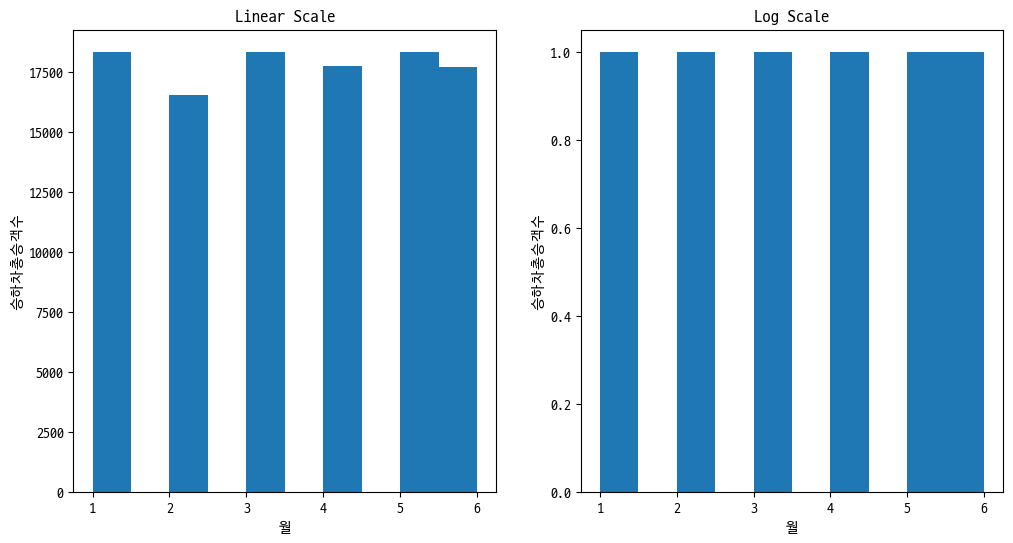

5월에 가장 많은 승객수 485,718,557명


,월,승차총승객수,하차총승객수,등록일자,연,승하차총승객수
4,5,243338053.0,242380504.0,370213478472,37020384,485718557.0
3,4,235928571.0,235005777.0,358359862392,35835231,470934348.0
2,3,233813277.0,232879549.0,370330953373,37032498,466692826.0
0,1,221848014.0,220898375.0,370165764399,37016346,442746389.0
5,6,221547039.0,220663596.0,357858646377,35784756,442210635.0
1,2,190335812.0,189500198.0,334006895930,33400317,379836010.0


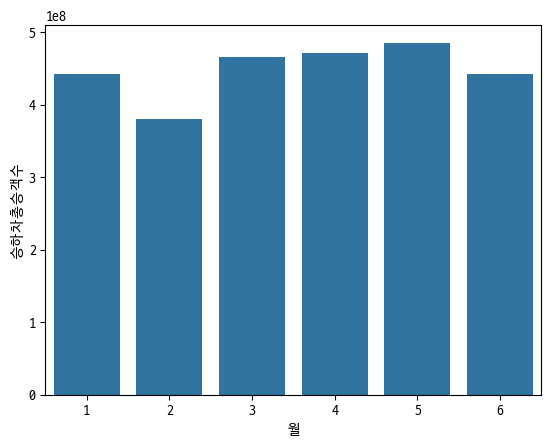

In [10]:
df = df_subway_raw.groupby('월') \
    .sum('승하차총승객수') \
    .reset_index() \
    .sort_values('승하차총승객수', ascending=False)

plt.figure(figsize=(12, 6))

# Linear Scale
plt.subplot(1, 2, 1)
plt.title('Linear Scale')
plt.xlabel('월')
plt.ylabel('승하차총승객수')
plt.hist(df_subway_raw['월'])

# Log Scale
plt.subplot(1, 2, 2)
plt.title('Log Scale')
plt.xlabel('월')
plt.ylabel('승하차총승객수')
plt.hist(df['월'])

plt.show()

sns.barplot(data=df, x='월', y='승하차총승객수')

row = df.iloc[0]
print(f'{row['월']:.0f}월에 가장 많은 승객수 {row['승하차총승객수']:,.0f}명')

df

### 3. 가설) 요일중에서 목요일에 지하철 승객수가 많다? (기준:승하차총승객수)

금요일에 가장 많은 승객수 445,310,717명


,요일,승차총승객수,하차총승객수,등록일자,연,월,승하차총승객수
0,금,223054017.0,222256700.0,310467474783,31046163,54416,445310717.0
1,목,214736048.0,213948335.0,310568329148,31056258,53250,428684383.0
2,수,210947599.0,210186537.0,310346219583,31034049,53211,421134136.0
3,월,196122495.0,195433056.0,298615616386,29861010,52050,391555551.0
4,일,124156061.0,123367934.0,310083928085,31007802,54921,247523995.0
5,토,171426749.0,170523269.0,310305966081,31030011,54968,341950018.0
6,화,206367797.0,205612168.0,310548066877,31054239,52650,411979965.0


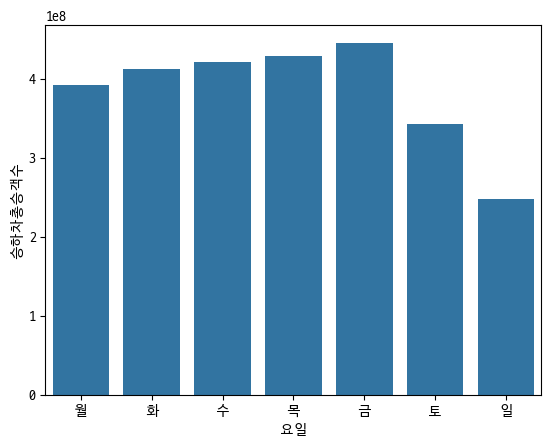

In [11]:
df = df_subway_raw.groupby('요일') \
    .sum('승하차총승객수') \
    .reset_index()

sns.barplot(data=df, x='요일', y='승하차총승객수', order=['월', '화', '수', '목', '금', '토', '일'])

row = df.sort_values(by='승하차총승객수', ascending=False).iloc[0]
print(f'{row['요일']}요일에 가장 많은 승객수 {row['승하차총승객수']:,.0f}명')

df

### 4. 연월 각각에 대해 일자별(월일별) 승하차총승객수 그래프 그려 볼까요? (pointplot)

<Axes: xlabel='사용일자', ylabel='승하차총승객수'>

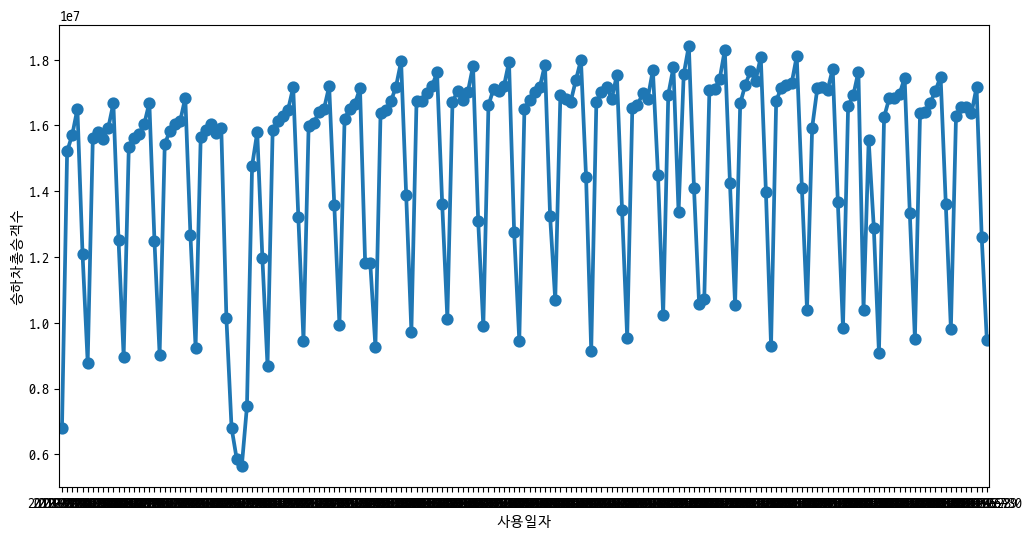

In [12]:
df = df_subway_raw.groupby('사용일자').sum('승하차총승객수').reset_index()

plt.figure(figsize=(12, 6))
sns.pointplot(data=df, x='사용일자', y='승하차총승객수')

### 5. 가장 승객이 많이 타는 승차역은?

잠실역이 가장 많은 승객수 18,574,323명


,역명,승차총승객수,하차총승객수,등록일자,연,월,승하차총승객수
413,잠실,18574323.0,18390074.0,7308916248,730878,1270,36964397.0


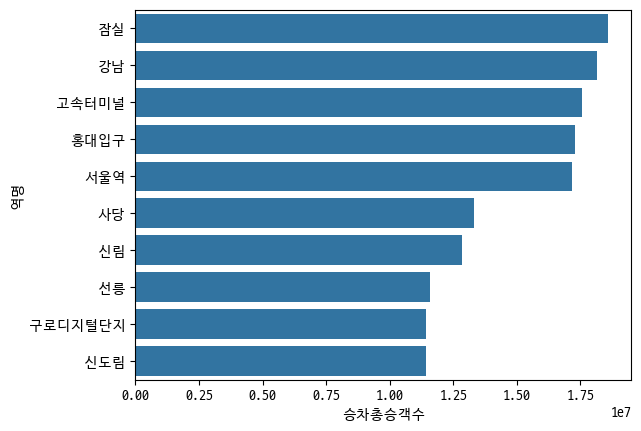

In [13]:
df = df_subway_raw.groupby('역명') \
    .sum('승차총승객수') \
    .reset_index() \
    .sort_values(by='승차총승객수', ascending=False)

row = df[['역명', '승차총승객수']].iloc[0]
print(f'{row["역명"]}역이 가장 많은 승객수 {row["승차총승객수"]:,.0f}명')

sns.barplot(data=df.head(10), x='승차총승객수', y='역명')

df.head(1)

### 6. 노선별로 역별/요일별 승차승객수를 비교해 볼수 있을까? (1~9호선, 역별/요일별 heatmap)

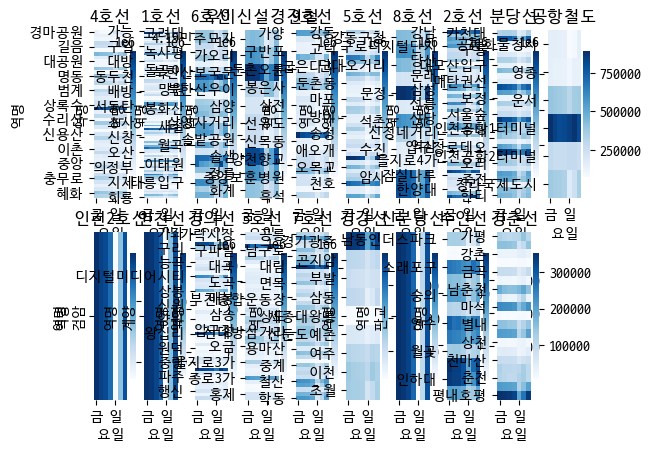

<Figure size 5000x1000 with 0 Axes>

In [14]:
n_lines = len(df_subway_raw['노선명'].unique())

SIZE = 5

W = 10
H = math.ceil(n_lines / W)

for line_no, line in enumerate(df_subway_raw['노선명'].unique()):
    df = df_subway_raw[df_subway_raw['노선명'] == line] \
        .groupby(['역명', '요일']) \
        .sum('승하차총승객수') \
        .reset_index() \
        .pivot(index='역명', columns='요일', values='승하차총승객수')

    plt.subplot(H, W, line_no+1)
    plt.title(line)
    sns.heatmap(data=df, fmt=',.0f', cmap='Blues')

plt.figure(figsize=(SIZE*W, SIZE*H))
plt.show()

### 7. 1호선에서 가장 하차를 많이 하는 역은? (groupby)

,역명,승차총승객수,하차총승객수,등록일자,연,월,승하차총승객수
1,가산디지털단지,10111317.0,10571381.0,7308916248,730878,1270,20682698.0


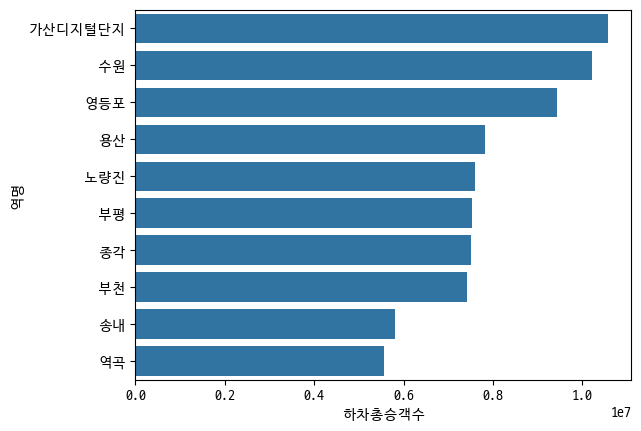

In [15]:
df = df_subway_raw[df_subway_raw['노선명'] == '1호선'] \
    .groupby('역명') \
    .sum('하차총승객수') \
    .reset_index() \
    .sort_values(by='하차총승객수', ascending=False)

sns.barplot(data=df.head(10), x='하차총승객수', y='역명')

df.head(1)

### 8. 2호선 중에서 어느 역에서 승차가 가장 많이 발생할까? (Folium 역 표시)

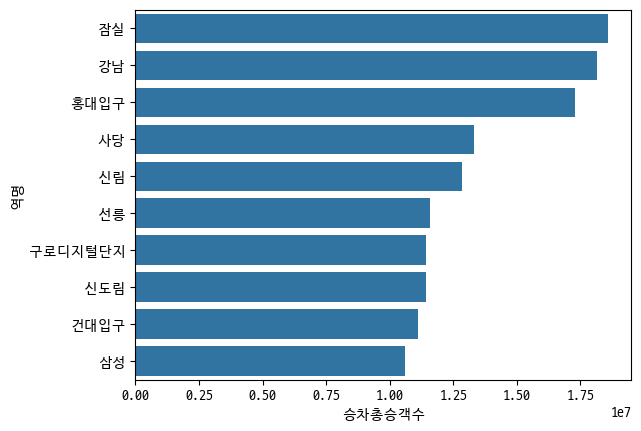

In [16]:
df = df_subway_raw[df_subway_raw['노선명'] == '2호선'] \
    .groupby('역명') \
    .sum('승차총승객수') \
    .reset_index() \
    .sort_values(by='승차총승객수', ascending=False)

sns.barplot(data=df.head(10), x='승차총승객수', y='역명')

target_station = df.iloc[0]['역명']

In [17]:
df = df_location_raw[df_location_raw['호선'] == '2호선'][df_location_raw['역이름'] == target_station]

foliun_map = folium.Map(location=[df['위도'], df['경도']], zoom_start=15)

folium.Marker(
    [df['위도'], df['경도']],
    popup=target_station,
).add_to(foliun_map)

foliun_map

/var/folders/ld/qthvz3k91_1239xs6fkx1zx00000gn/T/ipykernel_99390/1115473499.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = loc[loc['호선'] == '2호선'][loc['역이름'] == target_station]
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/venv/lib/python3.12/site-packages/folium/utilities.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/venv/lib/python3.12/site-packages/folium/utilities.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/venv/lib/python3.12/site-packages/folium/utilities.py:102: FutureWarning: Calling float on a single e